In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
import librosa
import soundfile as sf
from scipy.special import kl_div
from IPython.display import Audio
from librosa.sequence import dtw

In [3]:
# Load pipe-separated metadata
df = pd.read_csv("metadata.csv")
df.head()

wav_file  \
0  13b2068a-2def-4f69-b4ba-168c4da30498.wav   
1  f3429b2a-fcb2-4073-b17b-0529840bda6c.wav   
2  7086ebc0-3f6d-4947-ab2b-0b9289a42978.wav   
3  97311a8e-52a5-4b9e-be46-3ba6a29c39aa.wav   
4  81827e62-9599-4b47-8b1d-092e58677b34.wav   

                                          transcript  
0  I invite you to embark on a profound journey a...  
1  Meditation on the White Light This technique i...  
2  Meditation on the White Light This technique i...  
3  Meditation on the White Light This technique i...  
4  positive affirmations for me My business is co...

In [4]:
from kokoro import KPipeline

# Initialize the pipeline
pipeline = KPipeline(lang_code='a')  # 'a' = American English

In [5]:
def synthesize_and_save(text, output_path):
    gen = pipeline(text, voice='af_heart')
    audio_chunks = []
    for _, _, audio in gen:
        audio_chunks.append(audio.cpu().numpy())
    full_audio = np.concatenate(audio_chunks)
    sf.write(output_path, full_audio, 24000)
    return full_audio

def load_audio(path, sr=24000):
    audio, _ = librosa.load(path, sr=sr)
    return audio

In [6]:
def compute_l1_l2(gt, pred):
    min_len = min(len(gt), len(pred))
    gt, pred = gt[:min_len], pred[:min_len]
    l1 = np.mean(np.abs(gt - pred))
    l2 = np.mean((gt - pred)**2)
    return l1, l2

In [7]:
def compute_kl(gt, pred):
    min_len = min(len(gt), len(pred))
    gt = np.abs(gt[:min_len]) + 1e-8
    pred = np.abs(pred[:min_len]) + 1e-8
    gt /= np.sum(gt)
    pred /= np.sum(pred)
    return np.sum(kl_div(gt, pred))

In [8]:
def compute_dtw(gt, pred, sr=24000):
    # Convert to Mel spectrograms (or use MFCCs if desired)
    gt_spec = librosa.feature.melspectrogram(y=gt, sr=sr, n_mels=80)
    pred_spec = librosa.feature.melspectrogram(y=pred, sr=sr, n_mels=80)

    # Convert to log scale
    gt_db = librosa.power_to_db(gt_spec, ref=np.max)
    pred_db = librosa.power_to_db(pred_spec, ref=np.max)

    # Compute DTW
    D, wp = dtw(gt_db, pred_db, metric='euclidean')  # or use 'cosine'
    dtw_cost = D[-1, -1]

    return dtw_cost, D, wp

In [9]:
results = []

for i, row in df.sample(5).iterrows():
    text, filename = row["transcript"], row["wav_file"]
    true_path = f"audio files/{filename}"
    pred_path = f"synth_{i}.wav"

    pred_audio = synthesize_and_save(text, pred_path)
    
    true_audio = load_audio(true_path)
    pred_audio = load_audio(pred_path)

    l1, l2 = compute_l1_l2(true_audio, pred_audio)
    kl = compute_kl(true_audio, pred_audio)
    dtw_score, _, _ = compute_dtw(true_audio, pred_audio)

    print(f"\n--- Example {i+1} ---")
    print(f"Text: {text}")
    print(f"L1: {l1:.4f}, L2: {l2:.4f}, KL: {kl:.4f}")
    print(f"DTW Score: {dtw_score:.4f}")

    display(Audio(true_audio, rate=24000))  # Ground Truth
    display(Audio(pred_audio, rate=24000))  # Predicted

    results.append({"Text": text, "L1": l1, "L2": l2, "KL": kl, "DTW Score": dtw_score})



--- Example 414 ---
Text: Yo guys! Loki is here
L1: 0.0342, L2: 0.0030, KL: 3.2032
DTW Score: 10850.8976



--- Example 329 ---
Text: oops akshit fucked the beat
L1: 0.0233, L2: 0.0023, KL: 3.7752
DTW Score: 16943.5709



--- Example 152 ---
Text: "Close your eyes, if you feel comfortable, and begin to focus on your breath. Take a deep inhale through your nose and a long exhale through your mouth. Let your body settle into the space you re in, feeling the ground or surface beneath you."
L1: 0.0375, L2: 0.0032, KL: 2.9341
DTW Score: 94990.2988



--- Example 218 ---
Text: I told you not to bother me by sending me messages again and again When I message you then talk to me ok
L1: 0.0378, L2: 0.0032, KL: 4.1769
DTW Score: 74677.8615



--- Example 317 ---
Text: John deev , baby, Ok
L1: 0.0241, L2: 0.0022, KL: 3.9511
DTW Score: 21306.4421


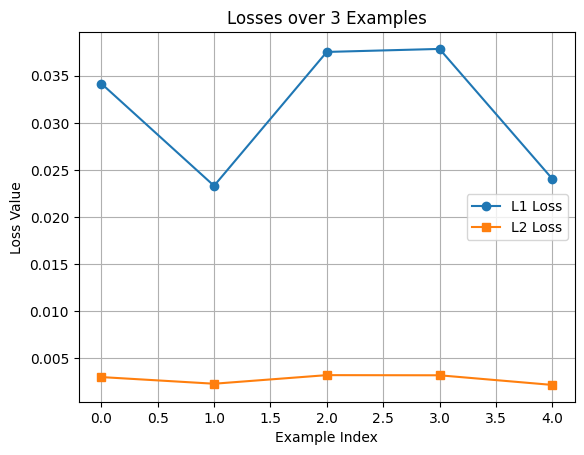

In [10]:
results_df = pd.DataFrame(results)

plt.plot(results_df.index, results_df['L1'], label="L1 Loss", marker="o")
plt.plot(results_df.index, results_df['L2'], label="L2 Loss", marker="s")
plt.title("Losses over 3 Examples")
plt.xlabel("Example Index")
plt.ylabel("Loss Value")
plt.legend()
plt.grid(True)
plt.show()


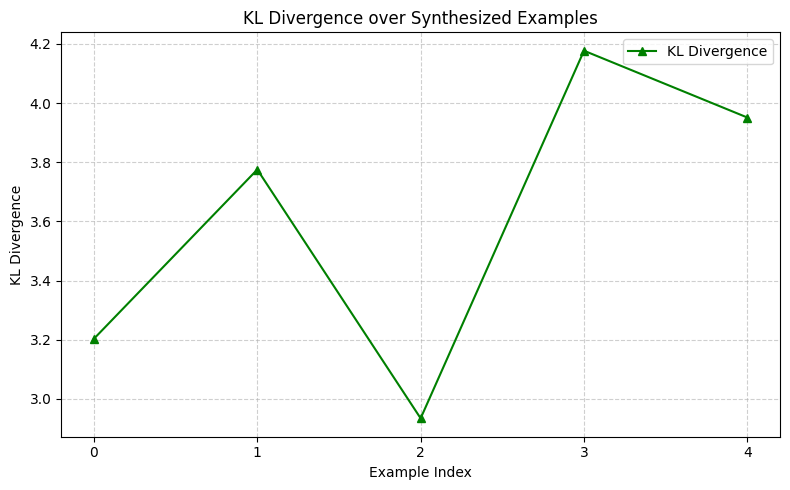

In [11]:
plt.figure(figsize=(8, 5))
plt.plot(results_df.index, results_df['KL'], label="KL Divergence", marker="^", linestyle='-', color='green')

plt.title("KL Divergence over Synthesized Examples")
plt.xlabel("Example Index")
plt.ylabel("KL Divergence")
plt.xticks(results_df.index)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


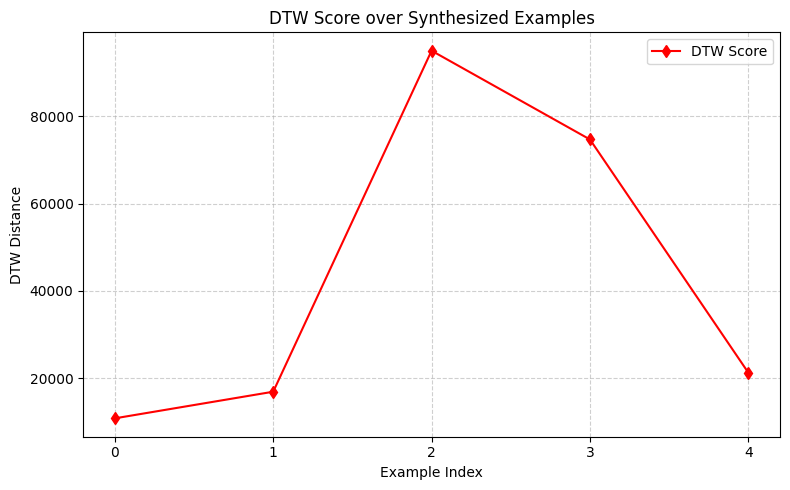

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(results_df.index, results_df['DTW Score'], label="DTW Score", marker="d", linestyle='-', color='red')

plt.title("DTW Score over Synthesized Examples")
plt.xlabel("Example Index")
plt.ylabel("DTW Distance")
plt.xticks(results_df.index)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
